![](../images/Title_ex_6.2.3.png)


# 1. Introduction
The FAO Map Catalog online portal offers a wide range of useful workspaces. In this notebook we will primarily focus on the Water Productivity Open-access portal (WaPOR), but keep in mind that other relevant datasets like ASIS and WPOP are also available through the same workflow. 

WaPOR is a public and freely available database that contains earth observation products to monitor agricultural water productivity over Africa and the Middle East. The product portfolio contains information on weather conditions (e.g. Precipitation), water consumption (e.g. Evapotranspiration) and land charachteristics (e.g. Land Cover and Primary/Biomass Production). The datasets are available from 2009 onwards at three different levels: 
- Level I at continental level (250 m ground resolution): Africa & Middle East
- Level II at country and river basin level (100 m ground resolution): Selection of African countries
- Level III at irrigation scheme and sub-basin level (30 m ground resolution): Selection 
More information on the WaPOR database and data availability can be found here: 
https://wapor.apps.fao.org/catalog/WAPOR_2/1

The WaPOR database can be accessed via webservices. In this excercise we will explore the WaPOR API. More explanation and examples can be found here: https://github.com/wateraccounting/WAPORWP 

The notebook outline: 

- [1. Introduction](#1.-Introduction)
- [2. Libraries](#2.-Loading-libraries)
- [3. General exploration of FAO workspace & WAPOR catalog](#3.-General-exploration-of-FAO-workspace-&-WAPOR-catalog)
- [4. Pixel time series extraction with Precipitation](#4.-Pixel-time-series-extraction-with-Precipitation-(PCP))
- [5. Area statistics time series with Actual EvapoTranspiration and Interception](#5.-Area-statistics-time-series-with-Actual-EvapoTranspiration-and-Interception-(AETI))
- [6. Extraction of TIFF files](#6.-Extraction-of-TIFF-files)
- [7. Application on drought](#7.-Application-on-drought)
- [8. Land Cover](#8.-Land-Cover)
- [9. Other Workspaces](#9.-Other-Workspaces)

The WaPOR products which we will investigate in this Notebook are Precipitation (PCP), Actual evapotranspiration and interception (AETI), phenology (PHE) and Land Cover (LC). 

- Precipitation (PCP) is an important factor when assessing drought induced stress as it is an important input of the soil water balance, and therefore water availability for vegetation. The WaPOR precipitation product is expressed in mm and can be extracted at four different time scales: daily, dekadal, monthly and annual. 

- The Actual EvapoTranspiration and Interception (AETI, in mm/day) is the sum of the soil evaporation (E), canopy transpiration (T), and evaporation from rainfall intercepted by leaves (I). Transpiration is the evaporated water loss through the stomata in vegetation. The value of each pixel represents the average daily ETIa in a given dekad. It is available in three time scales: dekadal, monthly and annual. 

- Phenology (PHE) is another important parameter when assessing drought in the context of agriculture. The phenology products indicate when a growing season starts, reaches its maximum and ends (usually due to harvest). This dataset is extremely useful if we only want to assess the impact of drought on crops during their growing season. It is a level II product expressed as the dekad corresponding with the start, max or end of the season. 

- Land Cover (LC): When doing a spatial analysis, it is always useful to derive data on the land cover/land use of your research area. For example, if we want to assess the impact of drought on grasslands, we do not want to look at non-grassland pixels. In order to demarcate or mask the pixels that represent grassland we can make a land cover mask. The WaPOR land cover data at 250 m resolution is based on the Copernicus Global Land Cover product of 2015 (https://land.copernicus.eu/global/products/lc). Specifically within WaPOR, this base product is updated each year to separate agriculture into irrigated and non-irrigated cropland.

The detailed product and algorithm description is provided in the Methodology Report of WaPOR (Chapter 2.1.6, avialable here https://www.fao.org/3/ca9894en/CA9894EN.pdf). 


# 2. Loading libraries

In [1]:
# In order to run this notebook several libraries need to be imported:
import requests
import pandas as pd
import geopandas as gpd
import json
import os 
from pathlib import Path
import matplotlib.pyplot as plt
import rioxarray
import numpy as np

# 3. General exploration of FAO workspace & WAPOR catalog

## 3.1 Exploration of available FAO workspaces
We will first connect to the FAO webservices, select the WAPOR catalog and explore the products. 

In [2]:
# In this cell a connection is made to the FAO API services and a list is 
# printed of all available workspaces. 

overview = False
paged = False
url_workspaces = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces?overview={overview}&paged={paged}'
# Get response
resp_workspaces = requests.get(url_workspaces) 
# read response as JSON string 
resp_dict_workspaces = resp_workspaces.json()
# convert to pandas dataframe (table)
df_workspaces = pd.DataFrame.from_dict(resp_dict_workspaces['response'])
df_workspaces

,code,caption,description,links,additionalInfo,tags
0,AQUAMAPS,Global spatial database on water and agriculture,Regional and global spatial datasets on water ...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
1,ASIS,Agriculture Stress Index System,ASIS allows countries to fine-tune parameters ...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
2,C2ATLAS,Climate Change ATLAS,C2ATLAS (Climate Change ATLAS - CSIC).The Clim...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
3,C3S,Copernicus Climate Change Service,The Copernicus Climate Change Service (C3S) wi...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
4,CHIRPS,Climate Hazard group InfraRed Precipitation wi...,Climate Hazard group InfraRed Precipitation wi...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
5,CROPWATCH,CropWatch,Cropwatch is China's leading agricultural moni...,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'creationDate': '1998-01-01', 'link': 'https:...",[{'name': 'CROP'}]
6,CRTB,Climate Risk Toolbox (CRTB),Climate Risk Toolbox (CRTB),"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,"[{'name': 'CRTB'}, {'name': 'ASSESSMENT'}, {'n..."
7,DLMF,Desert Locust Monitoring and Forecasting,DLMF-Desert Locust monitoring and forecasting....,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,[{'name': 'LOCUST'}]
8,FAOSTAT,FAO Corporate Statistical Database,FAOSTAT provides free access to food and agric...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
9,FROM_GLC,Finer Resolution Observation and Monitoring of...,Global land cover data are key sources of info...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,[{'name': 'LCC'}]


## 3.2 WAPOR Catalog exploration
Next we will list all available products in the WaPOR catalog.

In [3]:
# This cell prints an overview of the first products and writes 
# the entire list of products to a CSV file. 

outdir = Path('./results')
outdir.mkdir(exist_ok=True, parents=True)

workspace = 'WAPOR_2'
overview = False
paged = False

url_catalog = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp_catalog = requests.get(url_catalog).json()
df_catalog = pd.DataFrame.from_dict(resp_catalog['response'])
df_catalog.to_csv(outdir / f'{workspace}.csv')
df_catalog


,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
0,L1_GBWP_A,Gross Biomass Water Productivity,The annual Gross Biomass Water Productivity ex...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 1, 'context': 'LEVELS...",WAPOR_2,RASTER,101,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,L1_NBWP_A,Net Biomass Water Productivity,The annual Net Biomass Water Productivity expr...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 2, 'context': 'LEVELS...",WAPOR_2,RASTER,102,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
2,L1_AETI_A,Actual EvapoTranspiration and Interception (An...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 3, 'context': 'LEVELS...",WAPOR_2,RASTER,103,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
3,L1_AETI_M,Actual EvapoTranspiration and Interception (Mo...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 4, 'context': 'LEVELS...",WAPOR_2,RASTER,104,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
4,L1_AETI_D,Actual EvapoTranspiration and Interception (De...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 5, 'context': 'LEVELS...",WAPOR_2,RASTER,105,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
...,...,...,...,...,...,...,...,...,...,...,...
280,L3_GEZ_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 270, 'context': 'LEVE...",WAPOR_2,RASTER,30270,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
281,L3_KOG_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 271, 'context': 'LEVE...",WAPOR_2,RASTER,30271,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
282,L3_LAM_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 273, 'context': 'LEVE...",WAPOR_2,RASTER,30273,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
283,L3_ODN_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 276, 'context': 'LEVE...",WAPOR_2,RASTER,30276,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


## 3.3 WAPOR Catalog filtering
Next we will filter the WaPOR catalog for products that contain PCP, AETI, PHE, NPP or TBP. The list of remaining products contains the products (if available) from three levels L1_ (250m continental), L2_ (100m national) & L3_ (30m areas). 

In [4]:
filter_lst = ['PCP','AETI','PHE']

filter_str  = '|'.join([str(elem) for elem in filter_lst])
filter_fn_str  = '_'.join([str(elem) for elem in filter_lst])

df_catalog_filtered = (df_catalog[df_catalog['code'].str.contains(filter_str)])
df_catalog_filtered.to_csv(outdir / f'{workspace}_filter_fn_str.csv')
df_catalog_filtered

,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
2,L1_AETI_A,Actual EvapoTranspiration and Interception (An...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 3, 'context': 'LEVELS...",WAPOR_2,RASTER,103,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
3,L1_AETI_M,Actual EvapoTranspiration and Interception (Mo...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 4, 'context': 'LEVELS...",WAPOR_2,RASTER,104,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
4,L1_AETI_D,Actual EvapoTranspiration and Interception (De...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 5, 'context': 'LEVELS...",WAPOR_2,RASTER,105,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
16,L1_PCP_A,Precipitation (Annual),Precipitation data is delivered on a daily bas...,"{'format': 'Raster Dataset', 'unit': 'mm (1mm=...","[{'name': 'L1', 'index': 16, 'context': 'LEVEL...",WAPOR_2,RASTER,116,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
18,L1_PCP_M,Precipitation (Monthly),Precipitation data is delivered on a daily bas...,"{'format': 'Raster Dataset', 'unit': 'mm (1mm=...","[{'name': 'L1', 'index': 18, 'context': 'LEVEL...",WAPOR_2,RASTER,118,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
...,...,...,...,...,...,...,...,...,...,...,...
247,L3_MUV_PHE_S,"Phenology (Muvumba catchment, Rwanda - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D (dekad...","[{'name': 'L3', 'index': 219, 'context': 'LEVE...",WAPOR_2,RASTER,30219,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
248,L3_ODN_PHE_S,"Phenology (Office du Niger, Mali - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D', 'dat...","[{'name': 'L3', 'index': 220, 'context': 'LEVE...",WAPOR_2,RASTER,30220,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
249,L3_SED_PHE_S,"Phenology (Senegal Delta, Senegal - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D (dekad...","[{'name': 'L3', 'index': 222, 'context': 'LEVE...",WAPOR_2,RASTER,30222,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
250,L3_YAN_PHE_S,"Phenology (Yanze catchment, Rwanda - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D (dekad...","[{'name': 'L3', 'index': 223, 'context': 'LEVE...",WAPOR_2,RASTER,30223,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


## 3.4 WAPOR product selection & meta-data exploration
We will select the Level 1 product of dekadal Precipitation (L1_PCP_D) and look at the associated metadata.

In [5]:
# This cell prints the meta-data in the original dictionary format. 

catalog_code = 'L1_PCP_D'

workspace = 'WAPOR_2'
url_catalog = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{catalog_code}'
resp_code = requests.get(url_catalog).json()
resp_code

{'requestId': '74717e8d-dbda-4ff9-a7b6-dd9145e68c26',
 'timestamp': 1663072210403,
 'runtime': 3,
 'status': 200,
 'message': 'OK',
 'response': {'code': 'L1_PCP_D',
  'caption': 'Precipitation (Dekadal)',
  'description': 'Precipitation data is delivered on a daily basis. The source of this dataset is CHIRPS (Climate Hazards Group InfraRed Precipitation with Station) quasi-global rainfall dataset, starting from 1981 up to near present. The value of each pixel represents the average of daily precipitation in the dekad expressed in mm (1mm=1l/m² or 1mm=10m³/ha).',
  'additionalInfo': {'format': 'Raster Dataset',
   'unit': 'mm (1mm=1l/m² or 1mm=10m³/ha)',
   'dataType': 'Int16 (16bit Integer)',
   'conversionFactor': 'the pixel value in the downloaded data must be multiplied by 0.1',
   'noDataValue': -9999,
   'spatialResolution': 'Approximately 5km (0.05 degree)',
   'spatialExtent': 'Africa and Near East',
   'spatialReferenceSystem': 'EPSG:4326 - WGS84 - Geographic Coordinate System

Meta-data publication

In [6]:
# This cell prints the key charactersitics from the meta-data dictionary in a more structured manner. 

print('################# Thematic Details ###################################')
print('Code                        : ', resp_code['response']['code'])
print('Variable                    : ', resp_code['response']['caption'])
print('Description                 : ', resp_code['response']['description'])
print('Unit                        : ', resp_code['response']['additionalInfo']['unit'])
print('')
print('################# Data Type & Scaling ################################')
print('Data Type                   : ', resp_code['response']['additionalInfo']['dataType'])
print('conversion Factor           : ', resp_code['response']['additionalInfo']['conversionFactor'])
print('No Data Value               : ', resp_code['response']['additionalInfo']['noDataValue'])
print('')
print('################# Coverage & Spatial Information ######################')
print('Coverage                    : ', resp_code['response']['additionalInfo']['spatialExtent'])
print('Spatial Resolution          : ', resp_code['response']['additionalInfo']['spatialResolution'])
print('Reference system            : ', resp_code['response']['additionalInfo']['spatialReferenceSystem'])
print('')
print('################# Archive Availability & Periodicity ##################')
print('Periodicity                 : ', resp_code['response']['additionalInfo']['temporalResolution'])
print('Archive Availability        : ', resp_code['response']['additionalInfo']['temporalExtent'])
print('Near Real Time Availibility : ', resp_code['response']['additionalInfo']['nearRealTime'])
print('################# Methodology ##################')
print('Methodology                 : ', resp_code['response']['additionalInfo']['methodology'])


################# Thematic Details ###################################
Code                        :  L1_PCP_D
Variable                    :  Precipitation (Dekadal)
Description                 :  Precipitation data is delivered on a daily basis. The source of this dataset is CHIRPS (Climate Hazards Group InfraRed Precipitation with Station) quasi-global rainfall dataset, starting from 1981 up to near present. The value of each pixel represents the average of daily precipitation in the dekad expressed in mm (1mm=1l/m² or 1mm=10m³/ha).
Unit                        :  mm (1mm=1l/m² or 1mm=10m³/ha)

################# Data Type & Scaling ################################
Data Type                   :  Int16 (16bit Integer)
conversion Factor           :  the pixel value in the downloaded data must be multiplied by 0.1
No Data Value               :  -9999

################# Coverage & Spatial Information ######################
Coverage                    :  Africa and Near East
Spatial Resolut

# 4. Pixel time series extraction with Precipitation (PCP)

Now that we have explored the product details we will extract and plot a time series of dekadal precipitation data for a specific location. Subsequently we will have a look on how to extract a time series for multiple locations at once. The latter will be done with monthly precipitation data.

## 4.1 PCP time series for single location

### 4.1.1 Define a function to extract a time series for a point

In [7]:
def get_pixel_timeseries(workspace, product_code,
                         coordinates, crs,
                         start_date, end_date):
    '''
    Function to extract one or multiple pixel time series from the FAO portal.
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
    - coordinates: dictionary with keys representing label of the point
        and values the x,y coordinate pair in the CRS defined by the next parameter.
        In case of Geographic CRS, the order should be [lat, lon].
    - crs: EPSG code of projection system (int)
    - start_date: start date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
    - end_date: end date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
        
    The function will return a dataframe with time as index and each column
    representing the query result for an individual point.
    '''
    
    print('Making some preparations...')
    
    path_query = r'https://io.apps.fao.org/gismgr/api/v1/query/'
    
    crs = f'EPSG:{crs}'
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)
    
    # get datacube time dimension
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
    resp = requests.get(cube_url).json()
    items = pd.DataFrame.from_dict(resp['response']['items'])
    dimension = items[items.type=='TIME']['code'].values[0]
    print('DIMENSION: ', dimension)
    
    print('Sending query for each point...')
    npoints = len(coordinates.keys())
    i = 0    
    for label, coo in coordinates.items():
        
        print(f'Processing point {i+1} / {npoints}...')
        query = {
        "type": "PixelTimeSeries",
        "params": {
            "cube": {
            "code": product_code,
            "workspaceCode": workspace,
            "language": "en"
            },
            "dimensions": [
            {
                "code": dimension,
                "range": f"[{start_date},{end_date})"
            }
            ],
            "measures": [
            measure
            ],
            "point": {
            "crs": crs,            
            "x":coo[1],
            "y":coo[0]
            }
        }
        }
        
        resp_query = requests.post(path_query, json=query)
        resp = resp_query.json()
        results = resp['response']
        df = pd.DataFrame(results['items'], columns=['Time', label])
        df.index = pd.to_datetime(df['Time'], format='%Y-%m-%d')
        df = df.drop(columns=['Time'])
        if i == 0:
            df_fin = df
        else:
            df_fin = pd.merge(df_fin, df, left_index=True, right_index=True)  
        
        i += 1
        print('Query successful!')
        
    return df_fin

### 4.1.2 Call the function for a specific point

In [10]:
# Specify parameters for API query
coordinates = [14.801460, -13.616014]
point = {'test': coordinates}
crs = 4326  # lat/lon
product_code = "L1_PCP_D"
workspace = 'WAPOR_2'
start_date = "2009-01-01"
end_date = "2009-12-31"

output = get_pixel_timeseries(workspace, product_code,
                              point, crs,
                              start_date, end_date)
output.head()

Making some preparations...
MEASURE:  WATER_MM
DIMENSION:  DEKAD
Sending query for each point...
Processing point 1 / 1...
Query successful!


,test
Time,
2009-01-10,0.0
2009-01-20,0.0
2009-01-31,0.0
2009-02-10,0.0
2009-02-20,0.0


### 4.1.3 Plot time series
Based on the Pandas dataframe the PCP time series is visualized in a bar graph. Execute the cell and interpret the time series for your point. Have a look at the unit of the axis, what conversion should you do to retrieve the total precipitation during the year? Is there a clear dry and wet season? 

Text(0.5, 1.0, 'PCP time series example')

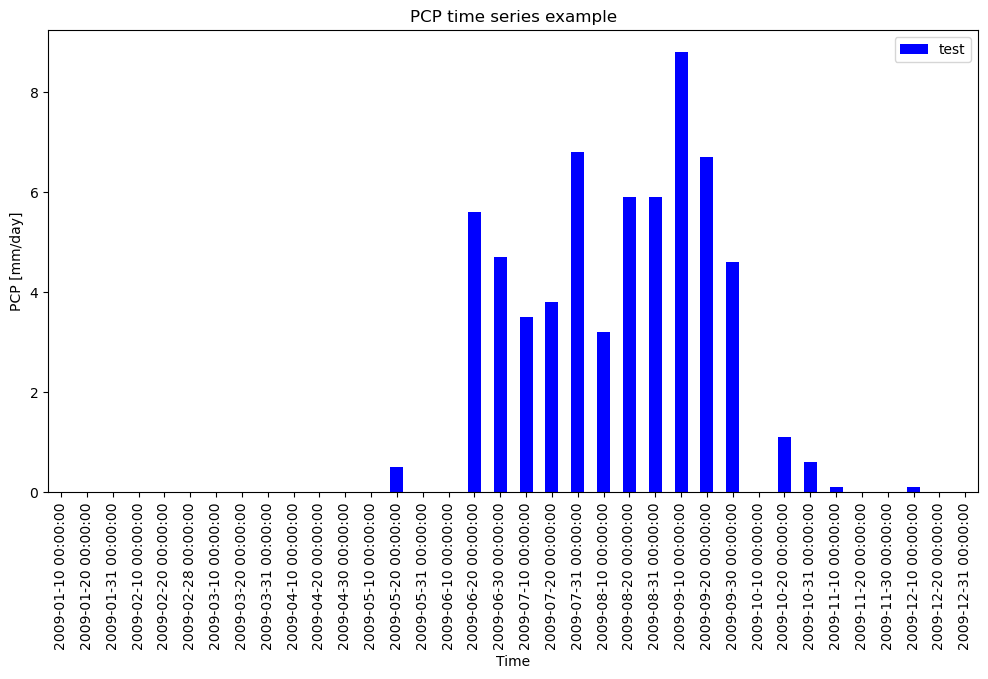

In [11]:
# Cell that generates a bar graph from the Pandas dataframe. 

figs, ax = plt.subplots(1, figsize=(12, 6))

output.plot.bar(ax=ax, color='blue')
ax.set_ylabel('PCP [mm/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('PCP time series example')

## 4.2 PCP time series for multiple locations
The previous extraction was focused on a single location. Next we will run the same function, but now for multiple locations  and visualize the outputs. The locations here follow a latidudinal gradient, feel free to enter your own locations of interest.

In [12]:
# Define the locations of interest
points_dict = {'Chad_centre': [14.756,18.851],
               'DRC_centre':[-1.9541,22.0243],
               'Botswana_centre':[-22.312,24.740],
               'South_Africa_south': [-34.459,19.838]}
crs = 4326  # lat/lon
# For this example we are going to look at the monthly precipitation
product_code = "L1_PCP_M"
workspace = 'WAPOR_2'
start_date = '2015-01-01'
end_date = '2018-01-01'

output = get_pixel_timeseries(workspace, product_code,
                              points_dict, crs,
                              start_date, end_date)
output.head()

Making some preparations...
MEASURE:  WATER_MM
DIMENSION:  MONTH
Sending query for each point...
Processing point 1 / 4...
Query successful!
Processing point 2 / 4...
Query successful!
Processing point 3 / 4...
Query successful!
Processing point 4 / 4...
Query successful!


,Chad_centre,DRC_centre,Botswana_centre,South_Africa_south
Time,,,,
2015-01-31,0.0,69.8,34.9,13.0
2015-02-28,0.0,135.3,12.1,14.5
2015-03-31,0.0,205.1,66.6,51.8
2015-04-30,0.0,171.9,40.0,20.9
2015-05-31,1.5,160.2,0.0,33.3


Text(0.5, 1.0, 'Monthly PCP time series example')

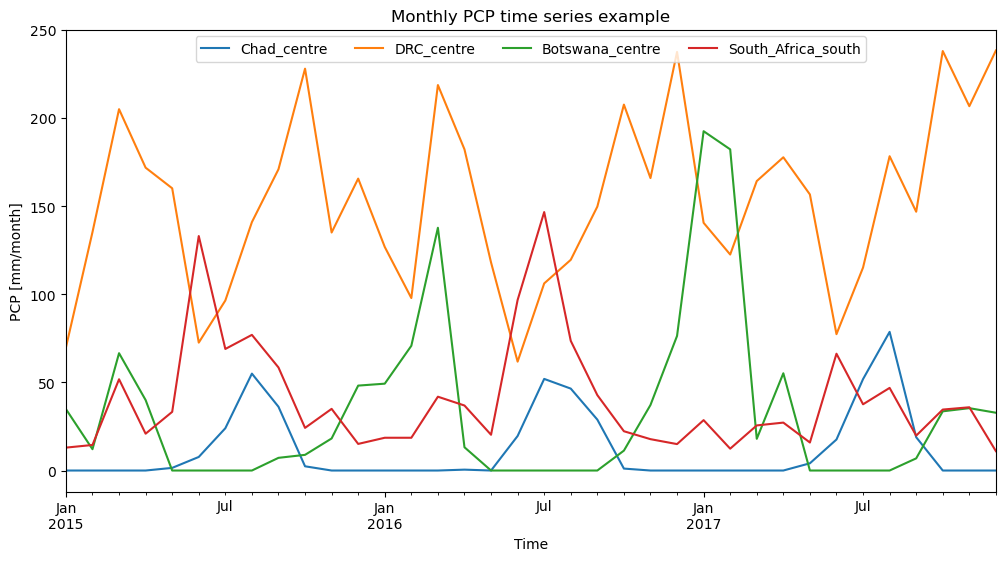

In [13]:
# Plot all time series and interpret the outcomes:
# Are there big differences amongst the locations? And can you explain them?

figs, ax = plt.subplots(1, figsize=(12, 6))
output.plot(ax=ax)
ax.set_ylabel('PCP [mm/month]')
ax.legend(loc='upper center', ncol=5)
ax.set_title('Monthly PCP time series example')

# 5. Area statistics time series with Actual EvapoTranspiration and Interception (AETI)

Up until now we ony focused on the time series of a single pixel. Imagine you want to evaluate a parameter over a larger area throughout time. Statistics like, mean, min, max and range can be calculated using code in the following section.

In order to use this workflow, you will need to ask access through your WaPOR personal API key. This is the key for you to log in WaPOR server with your account instead of using password. You can generate one from WaPOR portal - profile page: https://wapor.apps.fao.org/profile
If you haven't done so yet, please create a (free) account on the wapor portal before requesting this API key.

For more examples of area timeseries query load, 
visit [this webpage](https://io.apps.fao.org/gismgr/api/v1/swagger-ui/examples/AreaStatsTimeSeries.txt)

## 5.1 Define function to request area statistics

In [16]:
def request_timeseries_area_staticstics(workspace, product_code, crs,
                                        start_date, end_date,
                                        shapefile=None, labelcol=None,
                                        bbox=None):
  
    '''
    Function to extract area statistics for one or multiple polygons from the FAO portal.
    
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
   
    - crs: EPSG code of projection system (int)
    - start_date: start date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
    - end_date: end date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
    
    For spatial information, you can either provide a shapefile or a series of bounding boxes:
    - shapefile: path to shapefile containing one or multiple polygons for which data
      needs to be extracted.
    - labelcol: this parameter is only required if "shapefile" is provided and represents
      the name of the column in the shapefile which serves as a unique identifier for
      the polygons.
    - bbox: dictionary with keys representing label of the bbox
        and values the actual bounding box in the CRS defined by the next parameter and
        in the format [xmin, ymin, xmax, ymax].
        
    The function will return a list with dataframes, one dataframe for each polygon.
    '''
    
    # define necessary paths to the service
    path_query = r'https://io.apps.fao.org/gismgr/api/v1/query/'
    path_sign_in = r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'

    # request API token
    APIToken = input('Your API token: ')
    # Use this token to get access
    resp_signin = requests.post(path_sign_in, headers={'X-GISMGR-API-KEY': APIToken})
    resp_signin = resp_signin.json()
    AccessToken = resp_signin['response']['accessToken']
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)

    # get datacube time dimension
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
    resp = requests.get(cube_url).json()
    items = pd.DataFrame.from_dict(resp['response']['items'])
    dimension = items[items.type=='TIME']['code'].values[0]
    print('DIMENSION: ', dimension)
    
    # prepare spatial information, either from bbox or shapefile...
    crs = f'EPSG:{crs}'
    shapes = {}
    if bbox is not None:
        npoly = len(bbox.keys())
        for name, box in bbox.items():
            xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
            shape = [
                    [xmin,ymin],
                    [xmin,ymax],
                    [xmax,ymax],
                    [xmax,ymin],
                    [xmin,ymin]
                    ]
            shapes[name] = [shape]
            
    elif shapefile is not None:
      polys = gpd.read_file(shapefile)
      npoly = len(polys)
      names = polys[labelcol].values
      geometry = json.loads(polys.geometry.to_json())['features']
      for k, name in enumerate(names):
        shapes[name] = geometry[k]['geometry']['coordinates']

    else:
        raise ValueError('No spatial information provided!')
    
    print('Sending query for each polygon...')
    output = []
    i = 0    
    for label, geom in shapes.items():
      
      print(f'Processing polygon {i+1} / {npoly}...')
      
      # build query
      query = {
        "type": "AreaStatsTimeSeries",
        "params": {
          "cube": {
            "code": product_code,
        "workspaceCode": workspace,
        "language": "en"},
          "dimensions": [
            {
              "code": dimension,
              "range": f"[{start_date},{end_date})"}],
          "measures": [measure],
          "shape": {
            "type": "Polygon",
            "properties": {
              "name": crs},
            "coordinates": geom}}}
      
      # Post query
      resp_query = requests.post(path_query,
                                 headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                          json=query)
      resp_query = resp_query.json()
      job_url = resp_query['response']['links'][0]['href']
      
      # Get results
      j = 0
      print('RUNNING', end=" ")
      while j == 0:        
          resp = requests.get(job_url)
          resp = resp.json()
          if resp['response']['status']=='RUNNING':
              print('.', end =" ")
          if resp['response']['status']=='COMPLETED':
              results = resp['response']['output']
              out = pd.DataFrame(results['items'], columns=results['header'])
              j = 1
          if resp['response']['status']=='COMPLETED WITH ERRORS':
              print(resp['response']['log'])
              out = None
              j = 1
      
      output.append(out)

    return output

## 5.2 Apply function

Before we make the query we need to define the area of interest. This can be done in two ways: 
 - Define the area by a bounding box (bbox) coordinate extent
 - Define the area by reading a GeoJSON file (shapefile)

In this notebook, we'll only use a bounding box for now. Examples with shapefiles will be provided in other exercises...

In [17]:
# Dekadal actual evapotraspiration and interception on L1 level
product_code = "L1_AETI_D" 
workspace = 'WAPOR_2'

start_date = "2009-01-01"
end_date = "2019-01-01"

# coordinate reference system
crs = 4326
bbox = {'test': [37.95883206252312, 7.89534, 43.32093, 12.3873979377346]}

output = request_timeseries_area_staticstics(workspace, product_code, crs,
                             start_date, end_date, bbox=bbox)
# we provided one bounding box, so we should only be looking at the first element of the response...
aeti = output[0]
aeti.head()

MEASURE:  WATER_MM
DIMENSION:  DEKAD
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

,dekad,avg,min,max,range
0,2009-01-10,1.139956,0.0,8.6,8.6
1,2009-01-20,1.193750,0.0,6.6,6.6
2,2009-01-31,1.285700,0.0,7.0,7.0
3,2009-02-10,1.260122,0.0,9.1,9.1
4,2009-02-20,1.343921,0.0,9.5,9.5


## 5.3 Plot results

Text(0.5, 1.0, 'AETI per day for each dekad time series example')

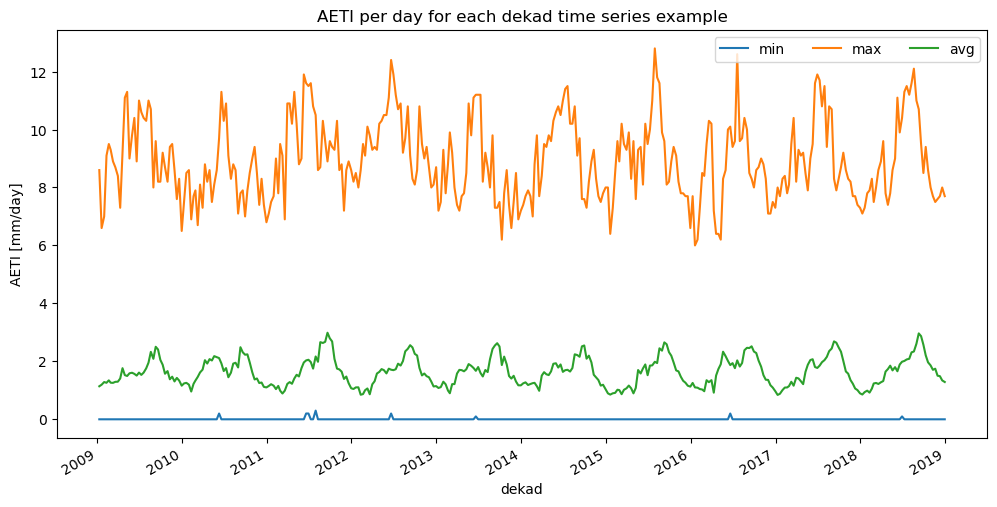

In [18]:
# make sure the index is in datetime format for nice plots
aeti.index = pd.to_datetime(aeti['dekad'],
                              format='%Y-%m-%d')

figs, ax = plt.subplots(1, figsize=(12, 6))
aeti['min'].plot(ax=ax, label='min')
aeti['max'].plot(ax=ax, label='max')
aeti['avg'].plot(ax=ax, label='avg')

ax.set_ylabel('AETI [mm/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('AETI per day for each dekad time series example')

# 6. Extraction of TIFF files

In the following section we shift our focus away from timeseries and look at how to download a cropped rasterfile of one of the WaPOR products. The procedure is very similar to previous section. Here we will again make use of our personal APIToken.

As an example we will demonstrate how to download the L2 seasonal phenology product (PHE).

## 6.1 Define a function to extract .tif files

In [19]:
def request_tif_files(workspace, product_code, crs,
                      outputfilename, dimensions,
                      shapefile=None, labelcol=None,
                      bbox=None):
    '''
    Function to extract .tif files for one or multiple polygons from the FAO portal.
    
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
   
    - crs: EPSG code of projection system (int)
    - dimensions: list of dimensions specifying the characteristics of the exact product
      you wish to download.
    
    For spatial information, you can either provide a shapefile or a series of bounding boxes:
    - shapefile: path to shapefile containing one or multiple polygons for which data
      needs to be extracted.
    - labelcol: this parameter is only required if "shapefile" is provided and represents
      the name of the column in the shapefile which serves as a unique identifier for
      the polygons.
    - bbox: dictionary with keys representing label of the bbox
        and values the actual bounding box in the CRS defined by the next parameter and
        in the format [xmin, ymin, xmax, ymax].
        
    The function will return a list of download links.
    '''
    
    # define necessary paths to the service
    path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
    path_sign_in=r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'

    # request API token
    APIToken = input('Your API token: ')
    # get access token
    resp_signin = requests.post(path_sign_in,
                              headers={'X-GISMGR-API-KEY': APIToken})
    resp_signin = resp_signin.json()
    AccessToken = resp_signin['response']['accessToken']
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)
    
    # prepare spatial information, either from bbox or shapefile...
    crs = f'EPSG:{crs}'
    shapes = {}
    if bbox is not None:
        npoly = len(bbox.keys())
        for name, box in bbox.items():
            xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
            shape = [
                    [xmin,ymin],
                    [xmin,ymax],
                    [xmax,ymax],
                    [xmax,ymin],
                    [xmin,ymin]
                    ]
            shapes[name] = [shape]
            
    elif shapefile is not None:
      polys = gpd.read_file(shapefile)
      npoly = len(polys)
      names = polys[labelcol].values
      geometry = json.loads(polys.geometry.to_json())['features']
      for k, name in enumerate(names):
        shapes[name] = geometry[k]['geometry']['coordinates']

    else:
        raise ValueError('No spatial information provided!')
    
    print('Sending query for each polygon...')
    output = []
    i = 0    
    for label, geom in shapes.items():
      
      print(f'Processing polygon {i+1} / {npoly}...')
      
      # build query
      query = {
      "type": "CropRaster",
      "params": {
        "properties": {
          "outputFileName": outputfilename,
          "cutline": True,
          "tiled": True,
          "compressed": True,
          "overviews": True
        },
        "cube": {
          "code": product_code,
          "workspaceCode": workspace,
          "language": "en"
        },
        "dimensions": dimensions,
        "measures": [
          measure
        ],
        "shape": {
          "type": "Polygon",
          "properties": {
              "name": crs},
          "coordinates": geom}}}
      
      # Post query
      resp_query = requests.post(path_query,
                                 headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                 json=query)
      resp_query = resp_query.json()
      job_url = resp_query['response']['links'][0]['href']
      
      # Get results
      j = 0
      print('RUNNING', end=" ")
      while j == 0:        
          resp = requests.get(job_url)
          resp = resp.json()
          if resp['response']['status']=='RUNNING':
              print('.', end =" ")
          if resp['response']['status']=='COMPLETED':
              results = resp['response']['output']
              out = results['downloadUrl']
              j = 1
          if resp['response']['status']=='COMPLETED WITH ERRORS':
              print(resp['response']['log'])
              out = None
              j = 1
      
      output.append(out)

    return output

## 6.2 Apply function for bounding box

In other exercises, we will see some examples using a shapefile as input.

Each product in the WaPOR data portal has specific characteristics. For instance, phenology is available for different years, different seasons and comes as a series of different products (start of season, peak of season and end of season).
In order to know which characteristics need to be used in the data request, you can check the time dimension of the specific product you are interested in:

In [20]:
product_code = 'L2_PHE_S'
workspace = 'WAPOR_2'

# get datacube dimension(s)
cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
resp = requests.get(cube_url).json()
items = pd.DataFrame.from_dict(resp['response']['items'])
print("DIMENSIONS: ")
print(items)

DIMENSIONS: 
     code        caption workspaceCode  hierarchical  type  index  \
0    YEAR           Year       WAPOR_2         False  TIME      1   
1  SEASON         Season       WAPOR_2         False  WHAT      2   
2   STAGE  Growing Stage       WAPOR_2         False  WHAT      3   

                                               links  
0  [{'rel': 'self', 'href': 'https://io.apps.fao....  
1  [{'rel': 'self', 'href': 'https://io.apps.fao....  
2  [{'rel': 'self', 'href': 'https://io.apps.fao....  


So for phenology, you can see in the output above that we indeed need to specify a year, season and stage as input for the request...

In [21]:
# specify product
product_code = 'L2_PHE_S'
workspace = 'WAPOR_2'

# Set dimensions values to identify the raster data needed.
year = "[2017-01-01,2018-01-01)" 
stage = "SOS" # Start of season
season = "S1" # first season (note not all regions have two seasons in 1 year)
dimensions = [{"code": "SEASON",
              "values": [season]},
              {"code": "STAGE",
               "values": [stage]},
              {"code": "YEAR",
               "values": [year]}]

# indicate how you want to name your rasterfile
outputfileName = 'L2_PHE_17s1_s_clipped.tif'

# Define bounding box
crs = 4326
bbox = {'test': [37.95883206252312, 7.89534, 43.32093, 12.3873979377346]}

# call function
output = request_tif_files(workspace, product_code,
                           crs, outputfileName,
                           dimensions, bbox=bbox)
print(output)

MEASURE:  PHE
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/556b3e37-0230-4330-a11e-8b0eed2d73f2/L2_PHE_17s1_s_clipped.tif']


# 7. Application on drought

As we have seen in this notebook, the WaPOR database offers both precipiation (PCP) and actual evapotranspiration and interception (AETI) data. These two products can be combined to quickly assess when drought occurs. If the AETI exceeds the PCP, it can be an indicator of climatological drought.

## 7.1 Collect PCP data

In section 5 of this notebook we already retrieved AETI information from 2009-01-01 to 2019-01-01 in the bbox: (37.95883206252312, 7.89534, 43.32093, 12.3873979377346). Now let's collect the corresponding PCP data.

In [22]:
# coordinate reference system
crs = 4326 
# Define the area based on a bbox coordinate extent
bbox = {'test': [37.95883206252312, 7.89534, 43.32093, 12.3873979377346]}

# Dekadal precipitation on L1 level
product_code = "L1_PCP_D" 
workspace = 'WAPOR_2'

start_date = "2009-01-01"
end_date = "2019-01-01"

output = request_timeseries_area_staticstics(workspace, product_code, crs,
                             start_date, end_date, bbox=bbox)
# we provided one bounding box, so we should only be looking at the first element of the response...
pcp = output[0]
pcp.head()


MEASURE:  WATER_MM
DIMENSION:  DEKAD
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

,dekad,avg,min,max,range
0,2009-01-10,0.000178,0.0,0.3,0.3
1,2009-01-20,0.061838,0.0,2.2,2.2
2,2009-01-31,1.748355,0.0,6.2,6.2
3,2009-02-10,0.302820,0.0,2.1,2.1
4,2009-02-20,0.216178,0.0,1.9,1.9


## 7.2 Join the PCP and AETI data

We now have collected PCP and AETI area statistics from the same area over the same period of time as a dataframe. In order to do calculations and plot the data in a more convenient way, we can join the two dataframes.

In [23]:
# to join two datafrmaes, it is best to give both the same index format
# in order to match the corresponding data
pcp.index = pd.to_datetime(pcp['dekad'], format='%Y-%m-%d')
aeti.index = pd.to_datetime(aeti['dekad'], format='%Y-%m-%d')

# join the two relevant columns of a dataframe
df_pcp_aeti = pcp[['avg']].join(aeti[['avg']], lsuffix='_pcp', rsuffix='_aeti')
# calculate the difference
df_pcp_aeti['pcp-aeti'] = df_pcp_aeti['avg_pcp'] - df_pcp_aeti['avg_aeti']
# show dataframe
df_pcp_aeti.head()

,avg_pcp,avg_aeti,pcp-aeti
dekad,,,
2009-01-10,0.000178,1.139956,-1.139779
2009-01-20,0.061838,1.193750,-1.131912
2009-01-31,1.748355,1.285700,0.462655
2009-02-10,0.302820,1.260122,-0.957303
2009-02-20,0.216178,1.343921,-1.127744


## 7.3 Plot results

Inspect the plots below. Would you say this specific area is irrigated or not?

Text(0.5, 1.0, 'Comparison AETI and PCP dekadal time series')

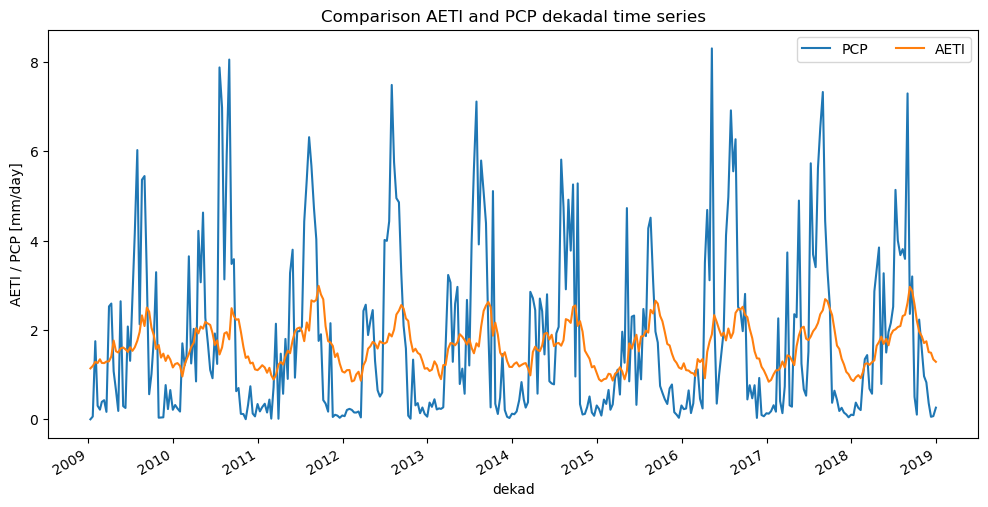

In [24]:
figs, ax = plt.subplots(1, figsize=(12, 6))
df_pcp_aeti['avg_pcp'].plot(ax=ax, label='PCP')
df_pcp_aeti['avg_aeti'].plot(ax=ax, label='AETI')

ax.set_ylabel('AETI / PCP [mm/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('Comparison AETI and PCP dekadal time series')

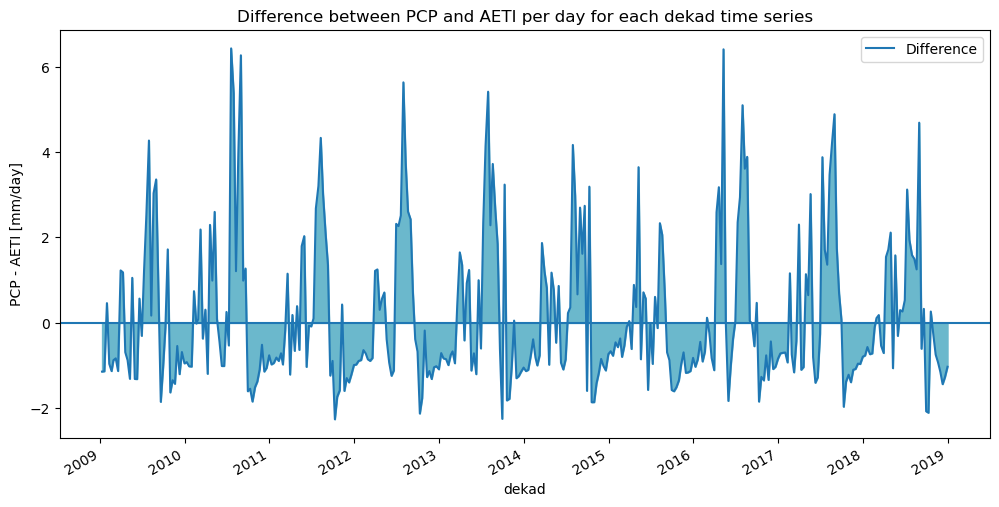

In [25]:
figs, ax = plt.subplots(1, figsize=(12, 6))
df_pcp_aeti['pcp-aeti'].plot(ax=ax, label='Difference')

ax.set_ylabel('PCP - AETI [mm/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('Difference between PCP and AETI per day for each dekad time series')
ax.axhline(y=0)
ax.fill_between(df_pcp_aeti.index, df_pcp_aeti['pcp-aeti'], color = '#6bb8cc')

# 8. Land Cover



## 8.1 Get data

Use the "request_tif_files" function defined above to request land cover information at 250 m resolution (L1) for the year 2020 and the following bounding box (in Ghana):

bbox = [-0.0656, 6.0378, 0.1814, 6.2072]

In [26]:
product_code = 'L1_LCC_A'
workspace = 'WAPOR_2'

# get datacube time dimension
cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
resp = requests.get(cube_url).json()
items = pd.DataFrame.from_dict(resp['response']['items'])
print(items)

   code caption workspaceCode  hierarchical  type  index  \
0  YEAR    Year       WAPOR_2         False  TIME      1   

                                               links  
0  [{'rel': 'self', 'href': 'https://io.apps.fao....  


In [27]:
# in the dimensions, we only need to specify the year...
year = '[2020-01-01,2021-01-01)'
dimensions = [{"code": "YEAR",
               "values": [year]}]

crs = 4326
bbox = {'test': [-0.0656, 6.0378, 0.1814, 6.2072]}

# indicate how you want to name your rasterfile
outputFileName = 'L1_LCC_clipped.tif' 

# call function
output = request_tif_files(workspace, product_code,
                           crs, outputFileName,
                           dimensions, bbox=bbox)
print(output)

MEASURE:  LCC
Sending query for each polygon...
Processing polygon 1 / 1...
RUNNING . . . . . . . . . . . . . . . . . . . . . ['https://io.apps.fao.org/gismgr/download/9f40e17b-6223-466f-bed5-4098361ddf90/L1_LCC_clipped.tif']


## 8.2 Read Copernicus Global Land Cover map

The pixel values correspond to a cetain land cover code and can be found under the 'Additional Information' here https://wapor.apps.fao.org/catalog/WAPOR_2/1/L1_LCC_A:

- 0: n.a 
- 20: Shrubland 
- 30: Grassland 
- 41: Cropland, rainfed 
- 42: Cropland, irrigated or under water management  
- 43: Cropland, fallow 
- 50: Built-up 
- 60: Bare / sparse vegetation 
- 70: Permament snow / ice 
- 80: Water bodies 
- 81: Temporary water bodies 
- 90: Shrub or herbaceous cover, flooded 
- 111: Tree cover: closed, evergreen needle-leaved 
- 112: Tree cover: closed, evergreen broadleaved 
- 114: Tree cover: closed, deciduous broadleaved 
- 115: Tree cover: closed, mixed type 
- 116: Tree cover: closed, unknown type 
- 121: Tree cover: open, evergreen needle-leaved 
- 122: Tree cover: open, evergreen broadleaved 
- 123: Tree cover: open, deciduous needle-leaved 
- 124: Tree cover: open, deciduous broadleaved 
- 125: Tree cover: open, mixed type 
- 126: Tree cover: open, unknown type 
- 200: Sea water 
- 255: no data 

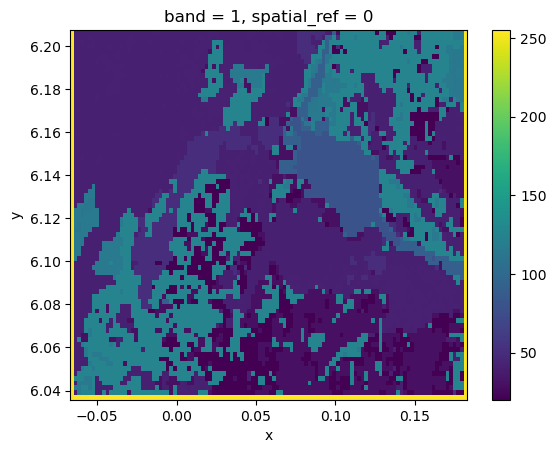

In [28]:
# once downloaded, move the resulting .tif file to the results folder and open the file:
LCC_img = rioxarray.open_rasterio('./results/L1_LCC_clipped.tif')
# extract the data from the image and store in a separate array
LCC_arr = LCC_img.values
# visualize the image
LCC_img.plot()
plt.show()

## 8.3 Make mask

Let's say we are only interested in the pixels that contain cropland.

The values that we want to keep are: 41, 42, 43

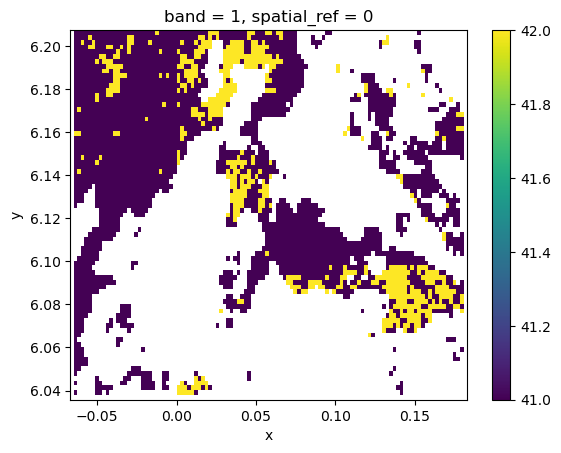

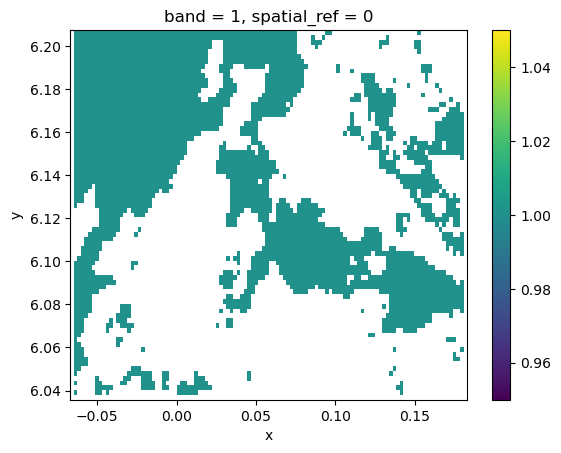

In [29]:
# first only show the relevant classes:
LCC_masked = LCC_img.where(LCC_img.isin([41,42,43]))
LCC_masked.plot()
plt.show()

# now create a mask with 1 (relevant class) and NaN
LCC_binary = LCC_masked.where(np.isnan(LCC_masked), 1)
LCC_binary.plot()
plt.show()

# export final mask to tiff file
outfile = './results/LCC_mask.tif'
LCC_binary.rio.to_raster(outfile)

# 9. Other Workspaces

As seen in section 3.1, the FAO Map Catalog offers more than WaPOR data. 

Some useful drought related data can also be found in the ASIS workspace. Have a look at the datacubes available in the ASIS workspace:

In [30]:
# List of workspace cubes
workspace = 'ASIS'
overview = False
paged = False
cubes_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp = requests.get(cubes_url).json()
catalog = pd.DataFrame.from_dict(resp['response'])
catalog

,code,caption,description,additionalInfo,workspaceCode,dataType,index,operation,hidden,links,tags
0,PRO,Progress of Season,The indicator depicts the development of crops...,"{'flags': [{'value': 250, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
1,VHI_D,Vegetation Health Index (Dekadal),The Vegetation Health Index (VHI) illustrates ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
2,VHI_M,Vegetation Health Index (Monthly),The Vegetation Health Index (VHI) illustrates ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
3,HDF,Historic Drought Frequency,Historic Agricultural Drought Frenquecy Maps d...,"{'flags': [{'value': 251, 'description': 'inco...",ASIS,RASTER,1,"{'pixelTimeSeries': False, 'areaStats': False}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
4,ASI_A,Agricultural Stress Index (Annual),The Annual ASI depicts the percentage of arabl...,"{'flags': [{'value': 251, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
5,ASI_D,"Agricultural Stress Index (Near Real Time, Dek...",The Agricultural Stress Index (ASI) is a quick...,"{'flags': [{'value': 251, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
6,VCI_M,Vegetation Condition Index (Monthly),The Vegetation Condition Index (VCI) evaluates...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
7,DI_A,Drought Intensity (Annual),Agricultural droughts are classified by their ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
8,VCI_D,Vegetation Condition Index (Dekadal),The Vegetation Condition Index (VCI) evaluates...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
9,MVHI_A,Mean Vegetation Health Index (Annual),The Mean Vegetation Health Index (Mean VHI) al...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN


Another interesting dataset is WPOP. It provides rasters with population density and count.

In [31]:
# List of workspace cubes
workspace = 'WPOP'
overview = False
paged = False
cubes_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp = requests.get(cubes_url).json()
catalog = pd.DataFrame.from_dict(resp['response'])
catalog

,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
0,WPOP_T,Total Population,Estimated total number of people per grid-cell...,"{'format': 'Raster Dataset', 'unit': 'ppl', 'd...","[{'name': 'L1', 'context': 'LEVELS_LIST'}, {'n...",WPOP,RASTER,1,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,WPOP_D,Human Population Density,Estimated density of people per grid-cell. The...,"{'format': 'Raster Dataset', 'unit': 'ppl/Km²'...","[{'name': 'L1', 'context': 'LEVELS_LIST'}, {'n...",WPOP,RASTER,2,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


In order to retrieve the data of interest please follow the steps in previous sections by altering the workspace (cubes), coordinates, timeframes, dimension and measures and so on. 

We will be further exploring the ASIS and WPOP datasets in the use case later on in the course.

Thank you for your attention and feel free to explore more datasets!